# Cryptocurrency Arbitrage

Crpytocurrency exchanges are web services that enable the purchase, sale, and exchange of cryptocurrencies. These exchanges provide liquidity for owners and establish the relative value of these currencies. As of this writing (mid-2022), [it is estimated](https://www.statista.com/statistics/730876/cryptocurrency-maket-value/) cryptocurrencies have a collective market capitalization of more than 2 trillion USD. Cryptocurrency markets are constantly changing with new currencies, exchanges, the occasional collapse of a currency, and highly volatile prices.

The purpose of this notebook is to explore the efficiency of cryptocurrency exchanges by testing for arbitrage opportunities. An arbitrage exists if a customer can realize a net profit through a sequence of risk-free trades. The efficient market hypothesis assumes arbitrage opportunities are quickly identified and exploited by investors. As a result of their trading, prices would reach a new equilibrium so that in an efficient market, any arbitrage opportunities would be small and fleeting. The question here is whether it is possible, with real-time data and rapid execution, for a trader to profit from these fleeting arbitrage opportunities.

## Installations and Imports

In [1]:
# install Pyomo and solvers
import requests
import types

url = "https://raw.githubusercontent.com/mobook/MO-book/main/python/helper.py"
helper = types.ModuleType("helper")
exec(requests.get(url).content, helper.__dict__)

helper.install_pyomo()
helper.install_cbc()

pyomo was previously installed
cbc was previously installed


True

In [2]:
import os
import sys
from time import time
from timeit import default_timer as timer

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pyomo.environ as pyo

## Cryptocurrency exchanges

Cryptocurrency exchanges are digital marketplaces for buying and trading cryptocurrencies. Joining an exchange enables a user to maintain multiple currencies in a digital wallet, to buy and sell currencies, and to use cryptocurrencies for financial transactions. The [open-source library `ccxt`](https://github.com/ccxt/ccxt) currently supports real-time APIs for the largest and most common exchanges on which cryptocurrencies are traded. Here we import the library and list current exchanges supported by `ccxt`.

In [3]:
import ccxt

for i, exchange in enumerate(ccxt.exchanges):
    print(f"{i+1:3d}) {exchange.ljust(20)}", end="" if (i+1) % 4 else "\n")

  1) aax                   2) ascendex              3) bequant               4) bibox               
  5) bigone                6) binance               7) binancecoinm          8) binanceus           
  9) binanceusdm          10) bit2c                11) bitbank              12) bitbay              
 13) bitbns               14) bitcoincom           15) bitfinex             16) bitfinex2           
 17) bitflyer             18) bitforex             19) bitget               20) bithumb             
 21) bitmart              22) bitmex               23) bitopro              24) bitpanda            
 25) bitrue               26) bitso                27) bitstamp             28) bitstamp1           
 29) bittrex              30) bitvavo              31) bkex                 32) bl3p                
 33) blockchaincom        34) btcalpha             35) btcbox               36) btcmarkets          
 37) btctradeua           38) btcturk              39) buda                 40) bw         

## Representing an exchange as a directed graph

Exchanges provide for trading between currencies. Trading done between two specific currencies is called a *market*; each exchange hosting multiple markets. `ccxt` labels each market with a market symbol that is common across exchanges and suitable for within-exchange and cross-exchange arbitrage analyses.

The market symbol is an upper case string with abbreviations for a pair of traded currencies separated by of a slash (`/`). The first abbreviation is the base currency, the second is the quote currency.  Prices for the base currency are denominated in units of the quote currency. As an example, the symbol `ETH/BTC` refers to a market for the base currency Ethereum (ETH) quoted in units of the Bitcoin(BTC). The same market symbol can refer to offer to sell the base currency (a 'bid'), or to an offer to sell the base currency (an 'ask').

An exchange can be represented by a directed graph can be constructed from the market symbols available on that exchange. Currencies correspond to nodes on the directed graph. Market symbols correspond to edges in the directed graph, with the source indicating the quote currency and the destination indicating the base currency.

The in-degree of a node is equal to the number of incoming edges. Out-degree is equal to the number of outgoing edges. Nodes with out-degrees greater than zero are highlighted because they represent currencies used to quote the price of other currencies. For all other nodes, a `minimum_in_degree` specifies a threshold value for in_degree for nodes to be displayed and retained for further analysis.



Number of nodes =  15
Number of edges =  50


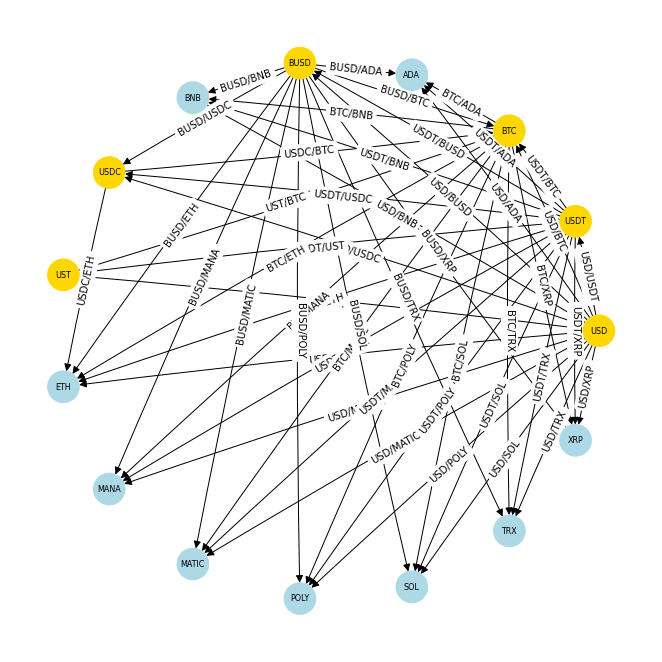

In [4]:
# global variables used in subsequent cells

exchange = ccxt.binanceus()
markets = exchange.load_markets()
symbols = exchange.symbols


def symbols_to_dg(symbols, minimum_in_degree=1):

    # create an edge for every symbol
    dg = nx.DiGraph()
    for base, quote in [symbol.split("/") for symbol in symbols]:
        dg.add_edge(quote, base)

    remove_nodes = []
    for node in dg.nodes():
        if dg.out_degree(node) > 0:
            # color quote currencies in gold
            dg.nodes[node]["color"] = "gold"
        else:
            if dg.in_degree(node) < minimum_in_degree:
                # remove base currencies with an insufficint in_degree
                remove_nodes.append(node)
            else:
                # color base currencies in lightblue
                dg.nodes[node]["color"] = "lightblue"

    dg.remove_nodes_from(remove_nodes)
    for u, v in dg.edges():
        dg[u][v]["color"] = "k"
        dg[u][v]["width"] = 1
    return dg


def draw_dg(dg, rad=0.0):
    n_nodes = len(dg.nodes)
    size = int(2.5 * np.sqrt(n_nodes))
    fig = plt.figure(figsize=(size, size))
    pos = nx.circular_layout(dg)
    nx.draw(
        dg,
        pos,
        with_labels=True,
        node_color=[dg.nodes[node]["color"] for node in dg.nodes()],
        edge_color=[dg.edges[u, v]["color"] for u, v in dg.edges],
        width=[dg.edges[u, v]["width"] for u, v in dg.edges],
        node_size=1000,
        font_size=8,
        arrowsize=15,
        connectionstyle=f"arc3, rad={rad}",
    )
    nx.draw_networkx_edge_labels(
        dg, pos, edge_labels={(src, dst): f"{src}/{dst}" for src, dst in dg.edges()}
    )


dg_symbols = symbols_to_dg(symbols, 4)
draw_dg(dg_symbols, 0.01)

print(f"Number of nodes = {len(dg_symbols.nodes()):3d}")
print(f"Number of edges = {len(dg_symbols.edges()):3d}")

## Exchange order book

The order book for a currency exchange is the real-time inventory of trading orders. 

A **bid** is an order to buy up to a specified amount of the base currency. The price is not to exceed the 'bid price' specified in the quote currency. The exchange attempts to match the bid to a sell order at a price less than or equal to the bid price. If a transaction occurs, the  buyer will receive an amount of base currency less than or equal to the bid volume at a price less than or equal to the bid price.

An **ask** is an offer to sell up to a specified amount of the base currency at a price no less than a value specified given in the quote currency. If a transaction occurs, then seller will sell no more than a specified about of the base currency at a price no less than the specified value if the exchange matches the ask order to a higher bid. 

The exchange order book maintains a list of all active orders for symbols traded on the exchange. Incoming bids above the lowest ask or incoming asks below the highest bid will be immediately matched and transactions executed following rules of the exchange. 

The following cell uses the `ccxt` library to fetch the highest bid and lowest ask from the order book for all trading symbols in a directed graph.

In [5]:
import pandas as pd

def fetch_order_book(dg):

    # get trading symbols from exchange graph
    trade_symbols = ["/".join([base, quote]) for quote, base in dg.edges()]

    def fetch_order_book_symbol(symbol, limit=1, exchange=exchange):
        """return order book data for a specified symbol"""
        start_time = timer()
        result = exchange.fetch_order_book(symbol, limit)
        result["base"], result["quote"] = symbol.split("/")
        result["run_time (ms)"] = round(1000 * (timer() - start_time), 1)
        result["timestamp"] = exchange.milliseconds()
        if result["bids"]:
            result["bid_price"] = result["bids"][0][0]
            result["bid_volume"] = result["bids"][0][1]
        if result["asks"]:
            result["ask_price"] = result["asks"][0][0]
            result["ask_volume"] = result["asks"][0][1]
        return result

    # fetch order book data and store in a dictionary
    order_book = {symbol: fetch_order_book_symbol(symbol) for symbol in trade_symbols}

    # convert to pandas dataframe
    order_book = pd.DataFrame(order_book).T
    order_book.drop(columns=["datetime", "symbol"], inplace=True)
    order_book["timestamp"] = pd.to_datetime(order_book["timestamp"], unit="ms")

    return order_book

order_book = fetch_order_book(dg_symbols)
display(order_book[['base', 'quote', 'bid_price', 'bid_volume', 'ask_price', 'ask_volume']])

,base,quote,bid_price,bid_volume,ask_price,ask_volume
ADA/USD,ADA,USD,0.3598,3300.0,0.3599,3300.0
BNB/USD,BNB,USD,273.0893,1.85,273.2163,1.85
BTC/USD,BTC,USD,19285.16,0.051852,19286.53,0.25169
BUSD/USD,BUSD,USD,1.0,688920.88,1.0001,281468.95
ETH/USD,ETH,USD,1344.68,1.2,1344.87,0.2
MANA/USD,MANA,USD,0.606,405.0,0.6064,405.0
MATIC/USD,MATIC,USD,0.8823,1300.0,0.8826,1300.0
POLY/USD,POLY,USD,NaN,NaN,NaN,NaN
SOL/USD,SOL,USD,28.1512,2.67,28.1568,17.75
TRX/USD,TRX,USD,0.0613,203542.7,0.0614,42676.5


## The order book as a directed graph

Here we represent the order book as a directed graph where nodes correspond to individual currencies. 

A directed edge $i\rightarrow j$ from node $i$ to node $j$ describes an opportunity for a counterparty to convert currency $i$ into units of currency $j$. Let $w_i$ and $w_j$ denote the amounts of each currency held by the counterparty, and let $x_{i\rightarrow j}$ denote the amount of currency $i$ exchanged for currency $j$. Following the transaction

$$\begin{align*}
\Delta w_i & = - x_{i\rightarrow j} \\
\Delta w_j & = a_{i\rightarrow j} x_{i\rightarrow j}
\end{align*}
$$

where $a_{i\rightarrow j}$ is a 'conversion' coefficient equal to the price of $i$ expressed in terms of currency $j$. The corresponding capacity $c_{i\rightarrow j}$ of an edge $i\rightarrow j$ is specified by a relationship

$$x_{i\rightarrow j} \leq c_{i\rightarrow j}$$

A buy order in the order book for market symbol $b/q$ is an order to purchase base currency $b$ at bid price given in the quote currency. The bid volume specifies the maximum amount base currency available. For a counterparty to the exchange, the buy order is an opportunity to convert the base currency $b$ into the quote currency $q$ such that

$$
\begin{align*}
a_{b\rightarrow q} & = \text{bid price} \\
c_{b\rightarrow q} & = \text{bid volume}
\end{align*}
$$

A sell order for symbol $b/q$ is an order to sell the base currency at price not less than the 'ask' price given in terms of the quote currency. The ask volume is the amount of base currency to be sold. For a counterparty to the exchange, a sell order is an opportunity to convert the quote current into the base currency such that

$$
\begin{align*}
a_{q\rightarrow b} & = \frac{1}{\text{ask price}} \\
c_{q\rightarrow b} & = \text{ask volume} \times \text{ask price}
\end{align*}
$$

The following cell creates a directed graph using data from an exchange order book.

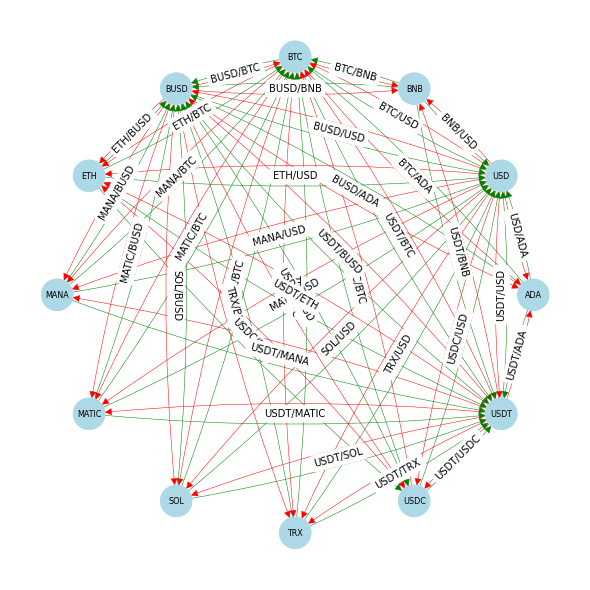

In [6]:
def order_book_to_dg(order_book):

    # create a dictionary of edges index by (src, dst)
    dg_order_book = nx.DiGraph()
    
    for symbol in order_book.index:
        # buy ('bid') orders
        if not np.isnan(order_book.at[symbol, "bid_volume"]):
            src = order_book.at[symbol, "base"]
            dst = order_book.at[symbol, "quote"]
            dg_order_book.add_edge(src, dst,
                kind = "bid",
                a = order_book.at[symbol, "bid_price"],
                capacity = order_book.at[symbol, "bid_volume"],
                weight = - np.log(order_book.at[symbol, "bid_price"]),
                color = "g",
                width = 0.5,
            )

        # sell ('ask') orders
        if not np.isnan(order_book.at[symbol, "ask_volume"]):
            src = order_book.at[symbol, "quote"]
            dst = order_book.at[symbol, "base"]
            dg_order_book.add_edge(src, dst,
                kind = "ask",
                a = 1.0 / order_book.at[symbol, "ask_price"],
                capacity = order_book.at[symbol, "ask_volume"] * order_book.at[symbol, "ask_price"],
                weight = - np.log(1.0 / order_book.at[symbol, "ask_price"]),
                color = "r",
                width = 0.5,
            )

    for node in dg_order_book.nodes():
        dg_order_book.nodes[node]["color"] = "lightblue"

    return dg_order_book


dg_order_book = order_book_to_dg(order_book)
draw_dg(dg_order_book, 0.05)

## Arbitrage

As counterparty to an exchange, an arbitrage exists if it is possible to find a closed path and a sequence of transactions in the directed graph that results in a net increase in currency holdings. Given a path

$$i_0 \rightarrow i_1 \rightarrow i_2 \rightarrow \cdots \rightarrow i_{n-1} \rightarrow i_n$$

the path is closed if $i_n = i_0$. The path has finite capacity if each edge in the path has a non-zero capacity. For a sufficiently small holding $w_{i_0}$ of currency $i_0$, the closed path with $i_0 = i_n$ represents an arbitrage opportunity if 

$$\prod_{k=0}^{n-1} a_{i_k\rightarrow i_{k+1}} > 1$$

To apply the shortest path algorithms from the NetworkX library, we assign a each edge a weight equal to the negative logarithm of the conversion coefficients.

$$w_{i\rightarrow j} = - \log a_{i\rightarrow j}$$

Given designated source and destination currencies represented by nodes $i_{0}$ and $i_{n}$, the largest return is given by a path minimizing the sum of weights computed as

$$
\begin{align*}
& \min\; W \\
& \text{s.t.}\; W = \sum_{k=0}^{n-1} w_{i_k \rightarrow i_{k+1}}\\
\end{align*}
$$

An arbitrage exists if $W < 0$ for any path where $i_0 = i_n$.

## Negative edge cycles

A brute force search over all simple cycles has complexity $(n + e)(c + 1)$ which is impractical for larger scale applications. A more efficient search based on Bellman-Ford is embedded in the NetworkX function [`negative_edge_cycle`](https://networkx.org/documentation/networkx-1.10/reference/generated/networkx.algorithms.shortest_paths.weighted.negative_edge_cycle.html) that returns a logical True if a negative cycle exists in a directed graph. 

In [7]:
dg_order_book = order_book_to_dg(order_book)
nx.negative_edge_cycle(dg_order_book, weight="weight", heuristic=True)

False

## Find order books that demonstrate arbitrage opportunities

In [17]:
from datetime import datetime
import time
import glob
timeout = time.time() + 5

# wait for arbitrage opportunity
while time.time() <= timeout:
    print(".", end="")
    order_book = fetch_order_book(dg_symbols)
    dg_order_book = order_book_to_dg(order_book)
    if nx.negative_edge_cycle(dg_order_book, weight="weight", heuristic=True):
        print("arbitrage found!")
        fname = f"{exchange} orderbook {datetime.utcnow().strftime('%Y%m%d_%H_%M_%S')}.csv".replace(" ", "_")
        order_book.to_csv(fname)
        print(f"order book saved to: {fname}")
        break
    
else:
    print("no arbitrage found")
    fname = sorted(glob.glob(f"{exchange}_orderbook*".replace(" ","_")))[-1]
    print(f"Order book retrieved from {fname}")
    order_book = pd.read_csv(fname)
    

..no arbitrage found
Order book retrieved from Binance_US_orderbook_20221025_10_47_25.csv


### Some examples

Waiting for arbitrage opportunities to appear on a specific exchange in real-time occasionally requires some patience. For convenience, the following cell loads provide access to a few previously saved order books.

In [15]:
# order_book = pd.read_csv("Binance_US_orderbook_2022-08-07_17:20:31.csv")   # large order book with a 5 bp arb opportunity
# order_book = pd.read_csv("Binance_US_orderbook_20220926_18:41:53.csv")   # small order book with a 1 bp arb opportunity

## Locate arbitrage opportunities with `find_negative_cycle`

The NetworkX library includes a function [`find_negative_cycle`](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.shortest_paths.weighted.find_negative_cycle.html) that locates a single negative edge cycle, if one exists.

['ETH', 'USD', 'BUSD']
['ETH', 'USD', 'BUSD'] -3.8215632891969165e-05
0.3821636311851506 basis points


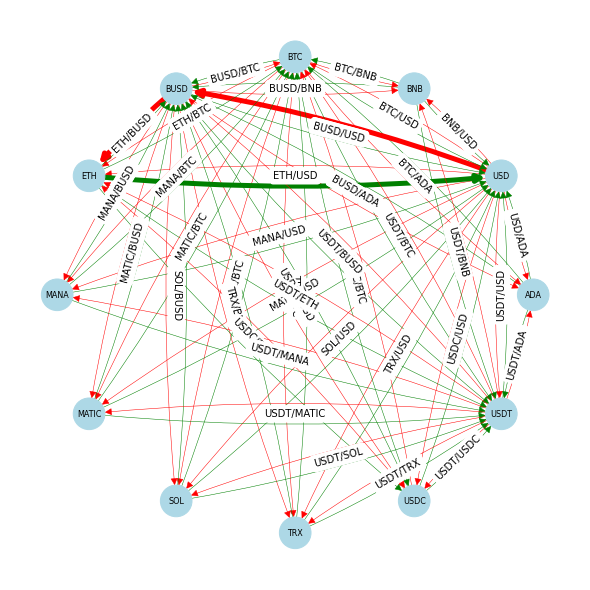

In [16]:
# compute the sum of weights given a list of nodes
def sum_weights(cycle):
    return sum([dg_order_book.edges[edge]["weight"] for edge in zip(cycle, cycle[1:] + cycle[:1])])


dg_order_book = order_book_to_dg(order_book)
arb = nx.find_negative_cycle(dg_order_book, weight="weight", source="USD")[:-1]
print(arb)
print(arb, sum_weights(arb))
print(f"{10000 * (np.exp(-sum_weights(arb)) - 1)} basis points")
    
for src, dst in zip(arb, arb[1:] + arb[:1]):
    dg_order_book[src][dst]["width"] = 5
    
draw_dg(dg_order_book, 0.05)

## Finding arbitrage with simple cycles

To demonstrate the existence of arbitrage in an order book, we compute the loss function for all simple cycles that can be constructed within a directed graph. 

A simple cycle is a closed path where no node appears twice. Simple cycles are distinct if they are not cyclic permutations of each other. The following cell uses [`simple_cycles`](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.cycles.simple_cycles.html) from the NetworkX library to construct a dictionary of all distinct simple cycles in the order book. Cycles are represented by an ordered list of nodes comprising the cycle. The existence of a simple cycle with negative log loss indicates an arbitrage opportunity.

The following cell uses `negative_edge_cycle` to test for an arbitrage opportunity in the current order book. If an arbitrage is found, the order book is saved to a `.csv` file for later analysis. If no arbitrage is found within the specified time limit, the most recent `.csv` file is returned instead.

There are 38293 distinct simple cycles in the order book.


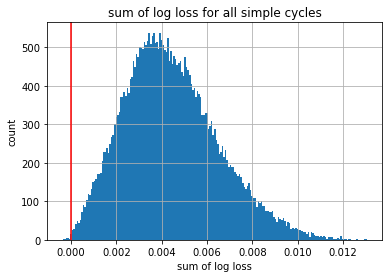

In [17]:
# This cell iterates over all simple cycles in a directed graph which
# can take inordinate time for a large, well connected graph. For that
# reason, it is included in "raw" format to avoid automatic execution 
# in scripts. Change to a "code" cell to execute.

# convert order book to a directed graph
dg_order_book = order_book_to_dg(order_book)

# compute the sum of weights given a list of nodes
def sum_weights(cycle):
    return sum([dg_order_book.edges[edge]["weight"] for edge in zip(cycle, cycle[1:] + cycle[:1])])

# create a dictionary of all simple cycles and sum of weights
cycles = dict()
for cycle in nx.simple_cycles(dg_order_book):
    cycles[tuple(cycle)] = sum_weights(cycle)

print(f"There are {len(cycles)} distinct simple cycles in the order book.")

# create histogram
plt.hist(cycles.values(), bins=int(np.sqrt(len(cycles))))
ax = plt.gca()
ax.set_ylabel("count")
ax.set_xlabel("sum of log loss")
ax.set_title("sum of log loss for all simple cycles")
ax.grid(True)
ax.axvline(0, color='r')

In [18]:
arbitrage = [cycle for cycle in sorted(cycles, key=cycles.get) if cycles[cycle] < 0]

print(f"basis points   arbitrage cycle")
for cycle in arbitrage:
    print(f"{10000*(np.exp(-cycles[cycle]) - 1):12.8f} {cycle}")

basis points   arbitrage cycle
  3.76516236 ('USDC', 'ETH', 'USD')
  2.76488587 ('USDC', 'ETH', 'USD', 'USDT')
  2.76488587 ('BUSD', 'USDT', 'USDC', 'ETH', 'USD')
  2.37311408 ('BUSD', 'USDT', 'USDC', 'ETH', 'USD', 'MATIC')
  2.08917952 ('USDC', 'ETH', 'USD', 'BTC', 'USDT')
  1.94506707 ('BUSD', 'BTC', 'USDT', 'USDC', 'ETH', 'USD')
  1.76460938 ('BUSD', 'USDC', 'ETH', 'USD')
  1.55332738 ('BUSD', 'BTC', 'USDT', 'USDC', 'ETH', 'USD', 'MATIC')
  1.38220185 ('BUSD', 'ETH', 'USD', 'USDC')
  1.37287677 ('BUSD', 'USDC', 'ETH', 'USD', 'MATIC')
  1.32852132 ('USDC', 'ETH', 'USD', 'ADA', 'USDT')
  1.17076168 ('BUSD', 'USDT', 'USDC', 'ETH', 'USD', 'BTC')
  0.76453293 ('BUSD', 'USDC', 'ETH', 'USD', 'USDT')
  0.38216363 ('BUSD', 'ETH', 'USD')
  0.38216363 ('BUSD', 'ETH', 'USD', 'USDT', 'USDC')
  0.17064460 ('BUSD', 'USDC', 'ETH', 'USD', 'BTC')
  0.15521985 ('USDC', 'ETH', 'USDT')
  0.15521985 ('USDC', 'ETH', 'USDT', 'USD')
  0.08896170 ('BUSD', 'USDC', 'ETH', 'USD', 'BTC', 'USDT')


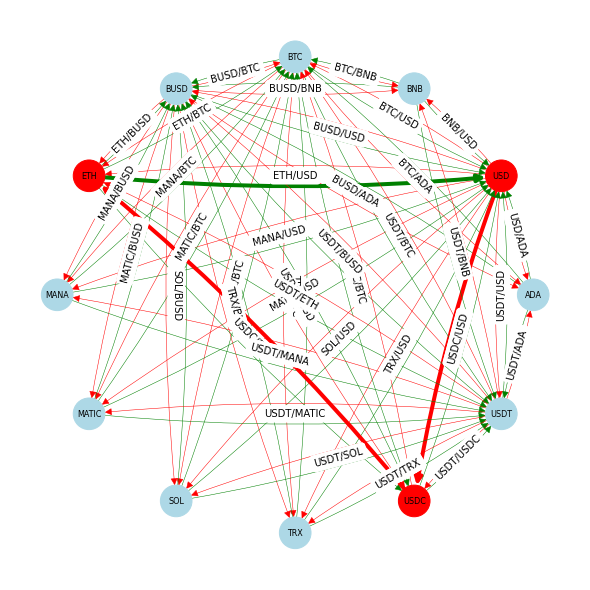

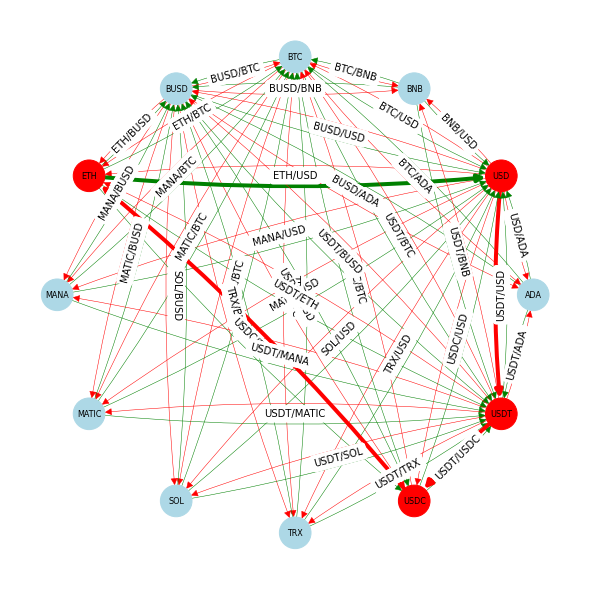

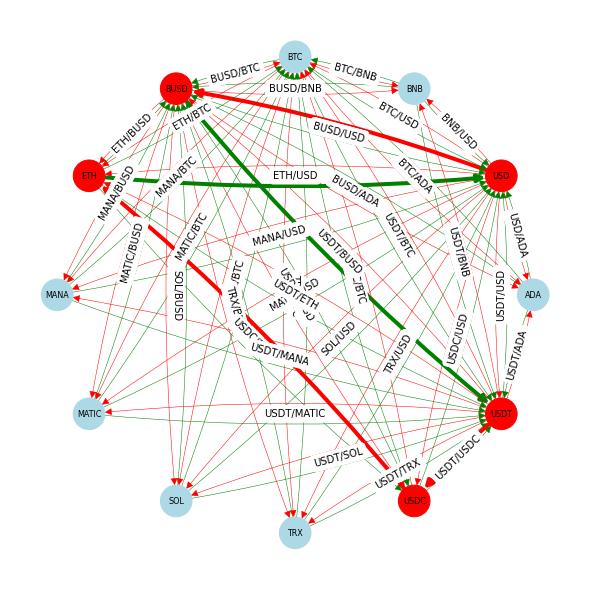

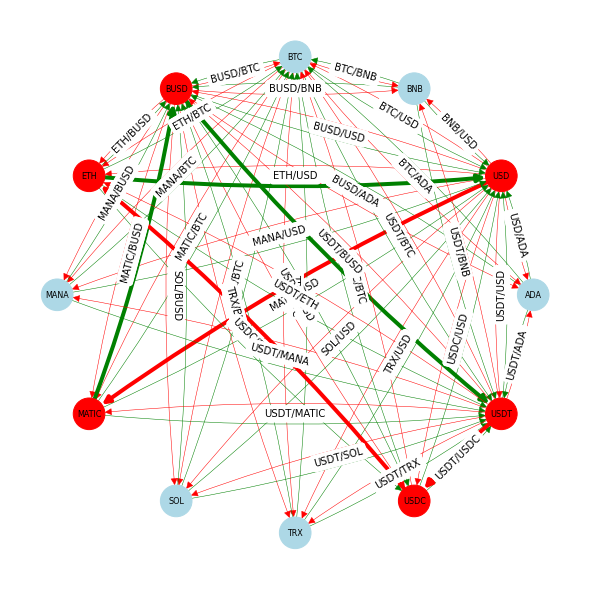

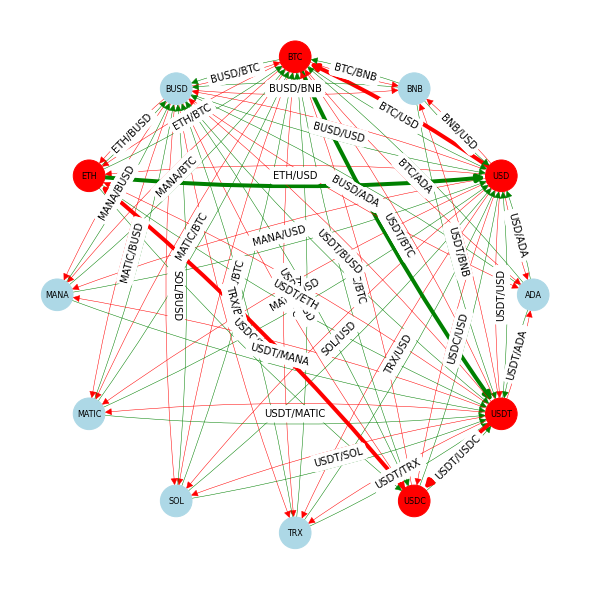

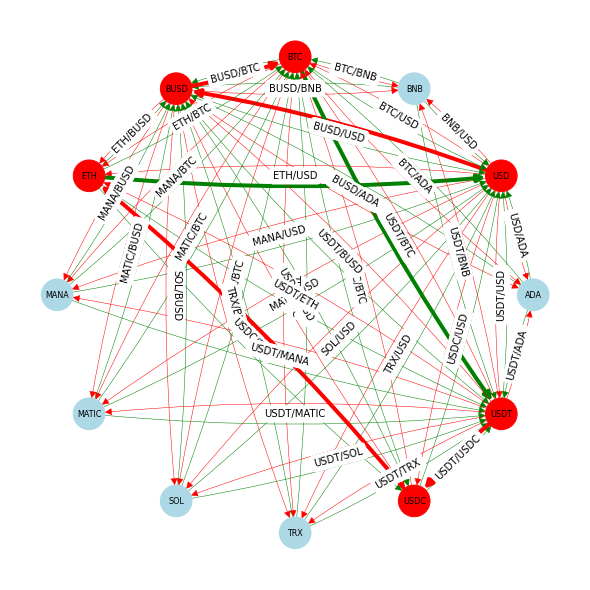

In [19]:
for k, cycle in enumerate(arbitrage):
    
    dg_order_book = order_book_to_dg(order_book)

    for node in cycle:
        dg_order_book.nodes[node]['color'] = 'red'
        
    color = 'r'
    for edge in zip(cycle, cycle[1:] + cycle[:1]):
        dg_order_book.edges[edge]['width'] = 4
        
    draw_dg(dg_order_book, rad=0.05)
    
    if k > 4:
        break

## Arbitrage with Capacity Constraints

The preceding analysis demonstrates some of the practical limitations of relying on generic implementations of network algorithms. 

* More than one negative cycle may exist, so more than one arbitrage opportunity may exist.
* Shortest path algorithms do not account for capacity constraints. In effect, these algorithms are restricted to investments that are 'sufficiently small' to satisfy all capacity constraints on all edges.

The following optimization model provides an alternative to network algorithms that includes:

* capacity constraints
* multi-step trading strategies
* no-short constraints

$$
\begin{align*}
\max \quad & w_{USD}(T) \\
\\
\text{s.t.} \quad & w_{USD}(0) = w_0 \\ \\
& w_{j}(t) = w_{j}(t-1) + \sum_{i\in I_k} a_{i\rightarrow j}x_{i\rightarrow j}(t) - \sum_{k\in O_k} x_{j\rightarrow k}(t) & \forall j\in N, t=1, 2, \ldots, T \\
& w_j(t-1) \geq \sum_{k\in O_k} x_{j\rightarrow k}(t) & \forall j\in N, t = 1, 2, \ldots, T  \\
& \sum_{t=1}^T x_{j, k}(t) \leq c_{j\rightarrow k} & \forall (j, k) \in N \times N\\
\end{align*}
$$

Orders
      arc          capacity        traded
  USD -> ETH   ask   1734.14800      499.99489  >>>  sell        0.374820 ETH/USD     at  1333.960000
 BUSD -> USD   bid 895307.05000      499.99864  >>>  buy       499.998640 BUSD/USD    at     1.000000
  ETH -> BUSD  bid      0.37482        0.37482  >>>  buy         0.374820 ETH/BUSD    at  1333.970000

Transactions
t = 1
USD      -> ETH     :     499.994890

t = 2

t = 3

t = 4

t = 5
ETH      -> BUSD    :       0.374820

t = 6
BUSD     -> USD     :     499.998640



,0,1,2,3,4,5,6
USD,1000.0,500.00511,500.00511,500.00511,500.00511,500.00511,1000.0037
BUSD,0.0,0.00000,0.00000,0.00000,0.00000,499.99864,0.0000
ETH,0.0,0.37482,0.37482,0.37482,0.37482,0.00000,0.0000


array([<AxesSubplot:title={'center':'USD'}>,
       <AxesSubplot:title={'center':'BUSD'}>,
       <AxesSubplot:title={'center':'ETH'}>], dtype=object)

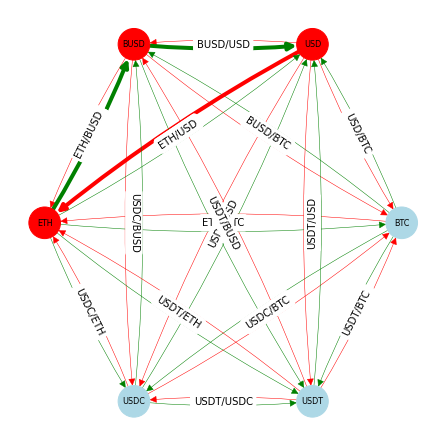

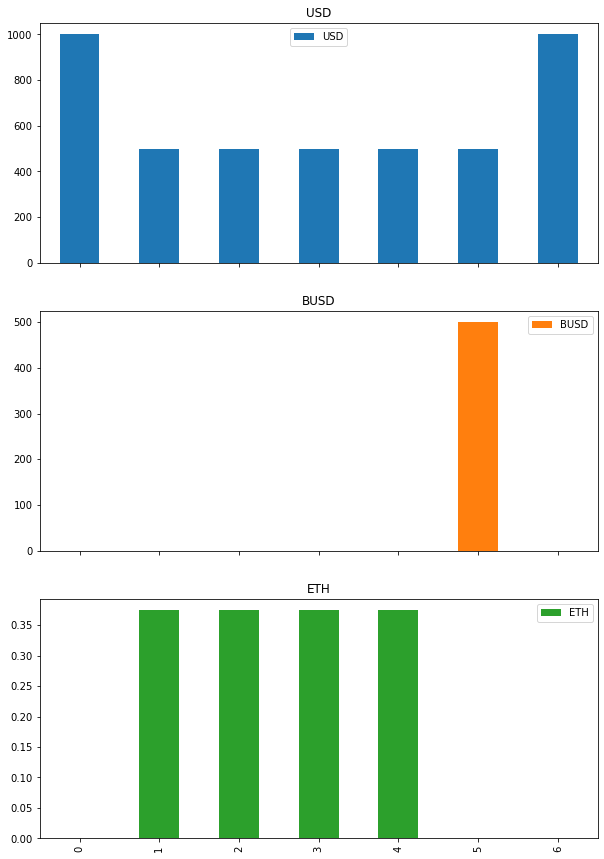

In [14]:
import pyomo.environ as pyo

def crypto_model(dg_order_book, T = 10, w0 = 1.0):

    m = pyo.ConcreteModel(f"{exchange} arbitrage")

    # length of the trading chain
    m.T0 = pyo.RangeSet(0, T)
    m.T1 = pyo.RangeSet(1, T)

    # currency nodes and trading edges
    m.NODES = pyo.Set(initialize=list(dg_order_book.nodes))
    m.EDGES = pyo.Set(initialize=list(dg_order_book.edges))

    # currency on hand at each node
    m.w = pyo.Var(m.NODES, m.T0, domain=pyo.NonNegativeReals)

    # amount traded on each edge at each trade
    m.x = pyo.Var(m.EDGES, m.T1, domain=pyo.NonNegativeReals)

    # total amount traded on each edge over all trades
    m.z = pyo.Var(m.EDGES, domain=pyo.NonNegativeReals)

    # "gain" on each trading edge
    @m.Param(m.EDGES)
    def a(m, src, dst):
        return dg_order_book.edges[(src, dst)]["a"]

    @m.Param(m.EDGES)
    def capacity(m, src, dst):
        return dg_order_book.edges[(src, dst)]["capacity"]

    @m.Objective(sense=pyo.maximize)
    def wealth(m):
        return m.w["USD", T]

    @m.Constraint(m.EDGES)
    def total_traded(m, src, dst):
        return m.z[src, dst] == sum([m.x[src, dst, t] for t in m.T1])

    @m.Constraint(m.EDGES)
    def edge_capacity(m, src, dst):
        return m.z[src, dst] <= m.capacity[src, dst]

    # initial assignment of 100 units on a selected currency
    @m.Constraint(m.NODES)
    def initial(m, node):
        if node == "USD":
            return m.w[node, 0] == w0
        return m.w[node, 0] == 0.0

    @m.Constraint(m.NODES, m.T1)
    def no_shorting(m, node, t):
        return m.w[node, t - 1] >= sum(m.x[node, dst, t] for src, dst in m.EDGES if src == node)

    @m.Constraint(m.NODES, m.T1)
    def balances(m, node, t):
        return m.w[node, t] == m.w[node, t - 1] \
            + sum(m.a[src, node] * m.x[src, node, t] for src, dst in m.EDGES if dst == node) \
            - sum(m.x[node, dst, t] for src, dst in m.EDGES if src == node) 


    solver = pyo.SolverFactory("cbc")
    solver.solve(m)
    
    return m

dg_order_book = order_book_to_dg(order_book)

m = crypto_model(dg_order_book, T=6, w0=1000)

# report what orders to issue
for src, dst in m.EDGES:
    if m.z[src, dst]() > 0.0000002: 
        dg_order_book.nodes[src]["color"] = "red"
        dg_order_book.nodes[dst]["color"] = "red"
        dg_order_book[src][dst]["width"] = 4
                
draw_dg(dg_order_book, 0.05)

# report what orders to issue
print("Orders")
print(f"      arc          capacity        traded")
for src, dst in m.EDGES:
    if m.z[src, dst]() > 0.0000002:
        kind = dg_order_book.edges[(src,dst)]['kind']
        
        s = f"{src:>5s} -> {dst:<5s} {kind} {m.capacity[src, dst]:12.5f} {m.z[src, dst]():14.5f}"
        s += "  >>>  "
        if kind == "ask":
            base = dst
            quote = src
            symbol = base + "/" + quote
            price = 1.0 / dg_order_book.edges[(src, dst)]["a"]
            volume = m.z[src, dst]() / price
            s += f"sell {volume:15.6f} {symbol:11s} at {price:12.6f}"
            
        if kind == "bid":
            base = src
            quote = dst
            symbol = base + "/" + quote
            price = dg_order_book.edges[(src, dst)]["a"]
            volume = m.z[src,dst]() 
            s += f"buy {volume:16.6f} {symbol:11s} at {price:12.6f}"
            
        print(s)
            
print("\nTransactions")
for t in m.T1:
    print(f"t = {t}")
    for src, dst in m.EDGES:
        if m.x[src, dst, t]() > 0.0000002:
            print(f"{src:8s} -> {dst:8s}: {m.x[src, dst, t]():14.6f}")
    print()

# display currency balances
balances = pd.DataFrame()
for node in dg_order_book.nodes:
    if sum(m.w[node, t]() for t in m.T0) > 0.0000002:
        for t in m.T0:
            balances.loc[t, node] = m.w[node, t]()

display(balances.T)
balances.plot(kind="bar", subplots=True, figsize=(10, 15))
plt.show()

## Bibliographic Notes

Crytocurrency markets are relatively new compared to other markets, and relatively few academic papers are available that specifically address arbitrage on those markets. Early studies, such as the following, reported periods of large, recurrent arbitrage opportunities that exist across exchanges, and that can persist for several days or weeks.

> Makarov, I., & Schoar, A. (2020). Trading and arbitrage in cryptocurrency markets. Journal of Financial Economics, 135(2), 293-319.

Subsequent work reports these prices differentials do exist, but only at a fraction of the values previously reported, and only for fleeting periods of time. 

> Crépellière, T., & Zeisberger, S. (2020). Arbitrage in the Market for Cryptocurrencies. Available at SSRN 3606053.  https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3606053

The use of network algorithms to identify cross-exchange arbitrage has appeared in the academic literature, and in numerous web sites demonstrating optimization and network applications. Representative examples are cited below.

> Peduzzi, G., James, J., & Xu, J. (2021, September). JACK THE RIPPLER: Arbitrage on the Decentralized Exchange of the XRP Ledger. In 2021 3rd Conference on Blockchain Research & Applications for Innovative Networks and Services (BRAINS) (pp. 1-2). IEEE. https://arxiv.org/pdf/2106.16158.pdf

> Bruzgė, R., & Šapkauskienė, A. (2022). Network analysis on Bitcoin arbitrage opportunities. The North American Journal of Economics and Finance, 59, 101562. https://doi.org/10.1016/j.najef.2021.101562

> Bruzgė, R., & Šapkauskienė, A. (2022). Dataset for Bitcoin arbitrage in different cryptocurrency exchanges. Data in Brief, 40, 107731. 

The work in this notebook is related to materials found in the following web resources.

> https://anilpai.medium.com/currency-arbitrage-using-bellman-ford-algorithm-8938dcea56ea

> [Crypto Trading and Arbitrage Identification Strategies](https://nbviewer.org/github/rcroessmann/sharing_public/blob/master/arbitrage_identification.ipynb)

A more complete analysis of trading and exploiting arbitrage opportunities in decentralized finance markets is available in the following paper and thesis.

> Byrne, S. An Exploration of Novel Trading and Arbitrage Methods within Decentralised Finance. https://www.scss.tcd.ie/Donal.OMahony/bfg/202021/StephenByrneDissertation.pdf

> Levus, R., Berko, A., Chyrun, L., Panasyuk, V., & Hrubel, M. (2021). Intelligent System for Arbitrage Situations Searching in the Cryptocurrency Market. In CEUR Workshop Proceedings (pp. 407-440). http://ceur-ws.org/Vol-2917/paper32.pdf

In addition to the analysis of arbitrage opportunities, convex optimization may also have an important role in the developing of trading algorithms for crypocurrency exchanges.

> Angeris, G., Agrawal, A., Evans, A., Chitra, T., & Boyd, S. (2021). Constant function market makers: Multi-asset trades via convex optimization. arXiv preprint arXiv:2107.12484. https://baincapitalcrypto.com/constant-function-market-makers-multi-asset-trades-via-convex-optimization/ and https://arxiv.org/pdf/2107.12484.pdf





## Appendix: Asynchronous downloads of order book data

Considerably more development, testing, and validation would be needed to adapt this code to an automated tradign bot to exploit arbitrage opportunities in the crypto-currency markets. One of the time consuming steps is accessing order book data. The following cell is an experiment using the Python `asyncio` library to determine if asynchronous calls to the `ccxt` would provide faster downloads. 

Preliminary testing shows little or no advantage to `asyncio` when working with a single exchange. That may change when the above code is adapted to multi-exchange arbitrage, and therefore this code is retained below for future testing.